Author:
        
        PARK, JunHo, junho@ccnets.org

        
        KIM, JeongYoong, jeongyoong@ccnets.org
        
    COPYRIGHT (c) 2024. CCNets. All Rights reserved.

In [1]:
import sys

path_append = "../" # Go up one directory from where you are.
sys.path.append(path_append) 

from nn.utils.init import set_random_seed
set_random_seed(0)

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torchvision.datasets as dset
from torchvision import transforms

# import albumentations
n_img_sz = 128
# Load the CelebA dataset for training. Specify the root directory where the dataset is located
trainset = dset.CelebA(root=path_append + '../data/celeba', split = "train", transform=transforms.Compose([
                            transforms.Resize(n_img_sz), # Transformations include resizing the images to `n_img_sz`
                            transforms.CenterCrop(n_img_sz), # Center cropping to the same size
                            transforms.ToTensor(), # Converting the images to tensors,
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalizing the pixel values to have a mean and standard deviation of 0.5 across all channels.
                        ]), download= True)

testset = dset.CelebA(root=path_append + '../data/celeba', split = "test", transform=transforms.Compose([
                            transforms.Resize(n_img_sz), # Transformations include resizing the images to `n_img_sz`
                            transforms.CenterCrop(n_img_sz), # Center cropping to the same size
                            transforms.ToTensor(), # Converting the images to tensors
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalizing the pixel values to have a mean and standard deviation of 0.5 across all channels.
                        ]), download= True)    

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# trainset = torch.utils.data.Subset(trainset, range(0, 10000))

In [4]:
label_list = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 
              'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 
              'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 
              'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 
              'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young' ]

causal_learning_selected_attributes = torch.tensor([label_list.index('Male')])
causal_learning_none_selected_attributes = torch.tensor([label_list.index('Smiling')])

In [5]:
# Custom dataset class for CelebA dataset
import torch
from torch.utils.data import Dataset
class CausalModelDataset(Dataset):
    def __init__(self, dataset, selected_attributes):
        self.dataset = dataset
        self.selected_attributes = selected_attributes
    
    def __getitem__(self, index):
        X, y = self.dataset[index]
        y = torch.index_select(y.unsqueeze(0), 1, self.selected_attributes).squeeze(0)
        return X, y
    
    def __len__(self):
        return len(self.dataset)
    
class EncodingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, index):
        return self.encodings[index], self.labels[index]
    
    def __len__(self):
        return len(self.encodings)

In [6]:
causal_model_dataset = CausalModelDataset(trainset, causal_learning_selected_attributes)

In [7]:
from tools.setting.ml_params import MLParameters
from tools.setting.data_config import DataConfig
from trainer_hub import TrainerHub
num_classes = 1
data_config = DataConfig(dataset_name = 'celebA', task_type='binary_classification', obs_shape=[3, n_img_sz, n_img_sz], \
                        label_size=num_classes, show_image_indices=[737, 1518, 390, 607])

#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_params = MLParameters(ccnet_network = 'resnet')

ml_params.training.num_epoch = 1
ml_params.algorithm.reset_pretrained = True
# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the TrainerHub class with the training configuration, data configuration, device, and use_print and use_wandb flags
trainer_hub = TrainerHub(ml_params, data_config, device)

Trainer Name: causal_trainer


ModelParameters Parameters:


,ccnet_config,ccnet_network,encoder_config,encoder_network
0,See details below,resnet,None,none



Detailed ccnet_config Configuration:


,ccnet_config_model_name,ccnet_config_num_layers,ccnet_config_d_model,ccnet_config_dropout,ccnet_config_obs_shape,ccnet_config_condition_dim,ccnet_config_z_dim
0,resnet,5,256,0.05,"[3, 128, 128]",2,128


TrainingParameters Parameters:


,batch_size,max_iters,max_seq_len,min_seq_len,num_epoch
0,64,100000,None,None,1


OptimizationParameters Parameters:


,clip_grad_range,decay_rate_100k,learning_rate,max_grad_norm,scheduler_type
0,None,0.05,0.0002,1.0,exponential


AlgorithmParameters Parameters:


,enable_diffusion,error_function,reset_pretrained
0,False,mse,True


DataConfig Parameters:


,dataset_name,task_type,obs_shape,label_size,explain_size,explain_layer,state_size,show_image_indices
0,celeba,binary_classification,"[3, 128, 128]",1,128,tanh,None,"[737, 1518, 390, 607]"



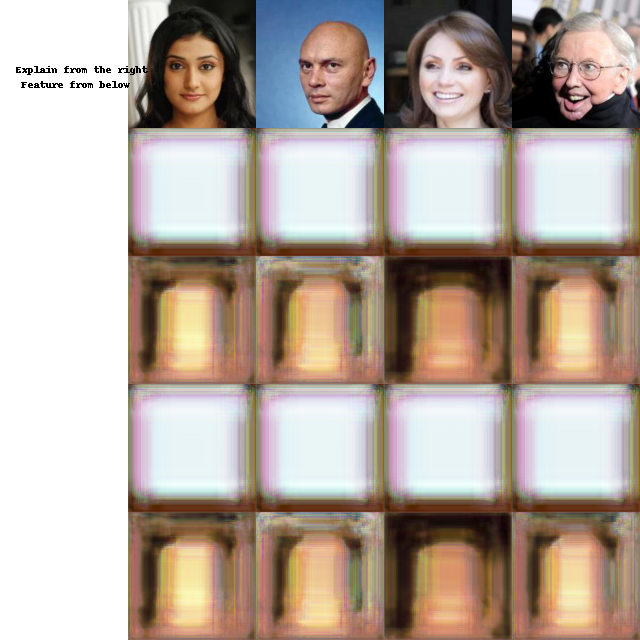

In [8]:
trainer_hub.train(causal_model_dataset)    

In [9]:
import torch
from torch.utils.data import DataLoader

def generate_encoding_dataset(dataset, selected_attribute, none_selected_attribute):
    data_loader = DataLoader(dataset=dataset, batch_size=256, shuffle=False, drop_last=False)

    encoding_tensor = None
    selected_attribute_tensor = None
    none_selected_attribute_tensor = None
    is_first = True
    causal_model = trainer_hub.ccnet

    for batch_idx, (images, attributes) in enumerate(data_loader):
        images = images.to(device)
        attributes = attributes.to(device)
        encoding = causal_model.explain(images)
        
        if is_first:
            is_first = False
            encoding_tensor = encoding
            selected_attribute_tensor = attributes[:, selected_attribute]
            none_selected_attribute_tensor = attributes[:, none_selected_attribute]
        else:
            encoding_tensor = torch.cat((encoding_tensor, encoding), dim=0)
            selected_attribute_tensor = torch.cat((selected_attribute_tensor, attributes[:, selected_attribute]), dim=0)
            none_selected_attribute_tensor = torch.cat((none_selected_attribute_tensor, attributes[:, none_selected_attribute]), dim=0)

    encoding_tensor = encoding_tensor.clone().detach().cpu()
    selected_attribute_tensor = selected_attribute_tensor.clone().detach().cpu()
    none_selected_attribute_tensor = none_selected_attribute_tensor.clone().detach().cpu()
    selected_attribute_dataset = EncodingDataset(encoding_tensor, selected_attribute_tensor)
    none_selected_attribute_dataset = EncodingDataset(encoding_tensor, none_selected_attribute_tensor)

    return selected_attribute_dataset, none_selected_attribute_dataset


In [10]:
trainset_with_selected_attributes, trainset_none_selected_attributes = generate_encoding_dataset(trainset, causal_learning_selected_attributes, causal_learning_none_selected_attributes)

# Optional: DataLoader for the created datasets
train_loader_with_selected_attributes = DataLoader(trainset_with_selected_attributes, batch_size=64, shuffle=True)
train_loader_with_none_selected_attributes = DataLoader(trainset_none_selected_attributes, batch_size=64, shuffle=True)

In [11]:
testset_with_selected_attributes, testset_with_none_selected_attributes = generate_encoding_dataset(trainset, causal_learning_selected_attributes, causal_learning_none_selected_attributes)

# Optional: DataLoader for the created datasets
test_loader_with_selected_attributes = DataLoader(testset_with_selected_attributes, batch_size=64, shuffle=True)
test_loader_with_none_selected_attributes = DataLoader(testset_with_none_selected_attributes, batch_size=64, shuffle=True)


In [12]:
class AttributeClassifier(torch.nn.Module):
    def __init__(self, input_size, output_size, num_layers=4, hidden_size=256):
        super(AttributeClassifier, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # Create a list to hold all layers
        layers = []
        
        # Input layer
        layers.append(torch.nn.Linear(input_size, hidden_size))
        layers.append(torch.nn.ReLU())
        
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(torch.nn.Linear(hidden_size, hidden_size))
            layers.append(torch.nn.ReLU())
        
        # Output layer
        layers.append(torch.nn.Linear(hidden_size, output_size))
        
        # Register all layers
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return torch.sigmoid(x)

In [13]:
# Function to train classifier
def train_classifier(model, train_loader, num_epoch=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epoch):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(data)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, labels)
            loss.backward()
            optimizer.step()
        
        print(f'\nEpoch {epoch + 1} / {num_epoch}')


In [14]:
# Function to evaluate classifier
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def test_classifier(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device).float()
            outputs = model(data)
            preds = torch.sigmoid(outputs).round()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(all_labels, all_preds))
    print(confusion_matrix(all_labels, all_preds))

In [15]:
# Train and evaluate classifiers on the explanation datasets
encoding_size = test_loader_with_selected_attributes.dataset.encodings.shape[-1]   
causal_classifier = AttributeClassifier(encoding_size, num_classes).to(device)
none_selected_classifier = AttributeClassifier(encoding_size, num_classes).to(device)

In [16]:
print("Training causal classifier on selected attributes...")
train_classifier(causal_classifier, train_loader_with_selected_attributes, num_epoch=5)

print("Training classifier on none selected attributes...")
train_classifier(none_selected_classifier, train_loader_with_none_selected_attributes, num_epoch=5)

Training causal classifier on selected attributes...

Epoch 1 / 5

Epoch 2 / 5

Epoch 3 / 5

Epoch 4 / 5

Epoch 5 / 5
Training classifier on none selected attributes...

Epoch 1 / 5

Epoch 2 / 5

Epoch 3 / 5

Epoch 4 / 5

Epoch 5 / 5


In [17]:
print("Testing causal classifier on selected attributes...")
test_classifier(causal_classifier, test_loader_with_selected_attributes)

print("Testing classifier on none selected attributes...")
test_classifier(none_selected_classifier, test_loader_with_none_selected_attributes)

Testing causal classifier on selected attributes...
Accuracy: 0.5783
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.73      5783
         1.0       0.00      0.00      0.00      4217

    accuracy                           0.58     10000
   macro avg       0.29      0.50      0.37     10000
weighted avg       0.33      0.58      0.42     10000

[[5783    0]
 [4217    0]]
Testing classifier on none selected attributes...
Accuracy: 0.5178
              precision    recall  f1-score   support

         0.0       0.52      1.00      0.68      5178
         1.0       0.00      0.00      0.00      4822

    accuracy                           0.52     10000
   macro avg       0.26      0.50      0.34     10000
weighted avg       0.27      0.52      0.35     10000

[[5178    0]
 [4822    0]]
